In [1]:
# Load necessary packages and datasets
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
df = pd.read_csv("./data/weather_with_avg_hourly_flight_delay.csv")
delay = df.copy()
delay.head()

DATE  HourlyAltimeterSetting  HourlyDewPointTemperature  \
0  2017-12-01T00:53:00                   30.14                       40.0   
1  2017-12-01T05:53:00                   30.08                       36.0   
2  2017-12-01T06:53:00                   30.07                       35.0   
3  2017-12-01T07:53:00                   30.06                       36.0   
4  2017-12-01T08:53:00                   30.06                       36.0   

   HourlyDryBulbTemperature  HourlySeaLevelPressure  HourlyStationPressure  \
0                      45.0                   30.16                  29.67   
1                      42.0                   30.10                  29.61   
2                      39.0                   30.09                  29.60   
3                      41.0                   30.09                  29.59   
4                      42.0                   30.08                  29.59   

   HourlyPressureChange  HourlyPressureTendency  HourlyVisibility  \
0                 -0.00                     3.0              10.0   
1                  0.00                     0.0              10.0   
2                  0.04                     6.0              10.0   
3                  0.00                     0.0              10.0   
4                  0.00                     0.0              10.0   

   HourlyWindSpeed          ...          REPORT_TYPE  cloud_1  cloud_0  \
0             13.0          ...                FM-15        0        1   
1             10.0          ...                FM-15        0        1   
2              8.0          ...                FM-15        0        1   
3              7.0          ...                FM-15        1        0   
4              9.0          ...                FM-15        0        1   

   wind_north  wind_east wind_south  wind_west   join_time  avg_delay  \
0           0          0          1          0  2017120100  -6.250000   
1           0          0          1          0  2017120105  -3.461538   
2           0          0          1          0  2017120106  -5.142857   
3           0          0          1          0  2017120107  10.714286   
4           0          0          1          0  2017120108   4.615385   

   actual_weather_delay  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0  

[5 rows x 25 columns]

In [2]:
# Drop all irrelevant features
delay.drop(['HourlySkyConditions', 'REPORT_TYPE', 'join_time','DATE', 'actual_weather_delay'], axis=1, inplace=True)

In [3]:
# Split the data for training and testing
train_features, test_features, train_outcome, test_outcome = train_test_split(
    delay.drop("avg_delay", axis=1),      # features
    delay.avg_delay,    # outcome
    test_size=0.30, # percentage of data to use as the test set
    random_state=11
)

In [4]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

In [5]:
# A grid search to get the best degree parameter of a polynomial regression
score_min = 99999
for order in range(1, 4):
    poly = PolynomialFeatures(degree = order)
    regr = linear_model.LinearRegression()
    new_train = poly.fit_transform(train_features)
    regr.fit(new_train, train_outcome)       
    new_test = poly.fit_transform(test_features)
    result = regr.predict(new_test)
    score = mean_squared_error(result, test_outcome)        
    if score < score_min:
        score_min = score
    print("n={}, MSE = {:<0.5}".format(order, score))

n=1, MSE = 189.95
n=2, MSE = 182.78
n=3, MSE = 765.31


In [6]:
# Using the best degree, train and fit on the training dataset
poly = PolynomialFeatures(degree = 2)
regr = linear_model.LinearRegression()
new_train = poly.fit_transform(train_features)
regr.fit(new_train, train_outcome)
result = regr.predict(new_train)
score = mean_squared_error(result, train_outcome)
print("Mean squared error = ", score)

Mean squared error =  162.60771387738248


In [7]:
# Test the polynomial model with the testing dataset
new_test = poly.fit_transform(test_features)
result = regr.predict(new_test)
score = mean_squared_error(result, test_outcome)
print("Mean squared error = ", score)

Mean squared error =  182.7768797754495


In [8]:
# Make predictions on the average hourly delay
p2 = regr.predict(poly.fit_transform(delay.drop("avg_delay", axis=1)))
delay['prediction'] = p2

In [9]:
import seaborn as sns

C:\Users\liang\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0.98, 'Polynomial model fit')

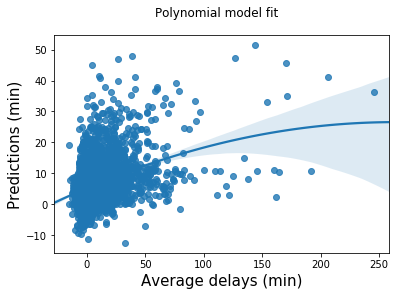

In [10]:
# Plot a fit diagram
sns.regplot(delay.avg_delay, delay.prediction, data=delay, order=2)
plt.xlabel('Average delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.suptitle("Polynomial model fit")

In [11]:
# Calculate the r squared value 
d_res = delay.avg_delay-delay.prediction
SSresid = sum(pow(d_res, 2))
SStotal = len(delay.avg_delay) * np.var(delay.avg_delay)
r_sqr = 1 - SSresid / SStotal
print(r_sqr)

0.1303642204758334


In [12]:
from sklearn.metrics import mean_absolute_error

In [13]:
# Calculate the mean absolute error
mean_absolute_error(delay.prediction, delay.avg_delay)

7.949535489449717

In [14]:
# Calculate the mean squared error
mean_squared_error(delay.prediction, delay.avg_delay)

168.65981456213396

In [15]:
plt.figure(figsize = (300, 100))
delay.prediction.plot(label="Predictions", fontsize = 200)
delay.avg_delay.plot(label="Actual")

plt.suptitle("Polynomial Predicted Delay vs. Actual average delay", fontsize = 200)
plt.legend(fontsize = 200)
plt.show()

In [16]:
# Calculate the percentage of flights that falls within 15 mins interval centered at 15 minutes interval
count = 0
for i in range(len(delay.avg_delay)):
    if abs(delay.avg_delay[i]-p2[i]) > 15: count += 1
'{:.2f}%'.format(100 - count / len(p2) * 100)

'90.21%'